In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from keras import regularizers, layers
from keras.layers import GlobalAveragePooling2D, Input, Flatten, Dropout, Dense, Conv2D, MaxPooling2D, BatchNormalization, concatenate
from keras.models import Model, Sequential
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from tqdm import tqdm
from keras.applications import MobileNetV2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l2

from keras.metrics import Recall,Precision,AUC,TruePositives,TrueNegatives,FalseNegatives,FalsePositives

import os
import pathlib

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
PATH=r"/content/drive/My Drive/Dataset"
RESIZE=768
BATCH_SIZE=16
NUM_EPOCHS=32
TEST_SIZE=0.3

In [7]:
def make_dataframes(sdir):
    filepaths=[]
    labels=[]
    files_include_txt=sorted(os.listdir(sdir))
    for files in files_include_txt:
        imagepath=os.path.join(sdir, files)
        #Melakukan kondisional isdir untuk hanya folder gambar saja
        if os.path.isdir(imagepath):
            file_name=sorted(os.listdir(imagepath))
            desc=f'{files:20s}'
            for f in tqdm(file_name, ncols=130,desc=desc, unit='files', colour='green'):
            # for f in file_name:
                fpath=os.path.join(imagepath,f)
                filepaths.append(fpath)
                labels.append(files)
    d1=pd.Series(filepaths, name='filepaths')
    d2=pd.Series(labels, name='labels')
    df=pd.concat([d1, d2], axis=1)

    #Dari 2146 file akan di displit 0.7 untuk latihan, 0.3 akan digunakan untuk validasi dan testing dengan split half
    train_df, dummy_df=train_test_split(df, train_size=1.-TEST_SIZE, shuffle=True, random_state=123, stratify=df['labels'])

    valid_df, test_df=train_test_split(dummy_df, train_size=.5, shuffle=True, random_state=123, stratify=dummy_df['labels'])

    classes=sorted(train_df['labels'].unique())
    num_classes = len(classes)
    #Menampilkan Kelas penyakit yang ada
    for disease in classes:
        print(f"{disease}, ", end=' ')
    print("/br")
    print('Jumlah kelas penyakit kulit yang terdapat di dataset = ', num_classes)
    print('Jumlah gambar sebagai training: ', len(train_df),
          '  Jumlah gambar sebagai testing: ', len(test_df),
          '  Jumlah gambar sebagai validasi: ', len(valid_df))
    return train_df, test_df, valid_df, classes, num_classes

train_df, test_df, valid_df, classes, NUM_CLASSES=make_dataframes(PATH)

Sel Basal           : 100%|██████████████████████████████████████████████████████████████| 357/357 [00:00<00:00, 381397.49files/s]


Acne,  Comedones,  Eczema,  Keratosis,  Melanoma,  Milia,  Perioral,  Rosacea,  Sel Basal,  /br
Jumlah kelas penyakit kulit yang terdapat di dataset =  9
Jumlah gambar sebagai training:  1502   Jumlah gambar sebagai testing:  322   Jumlah gambar sebagai validasi:  322


In [8]:
def make_generators(batch_size, train_df, test_df, valid_df, input_size):
    img_size = (input_size, input_size)
    preprocessing = keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
    train_gen=preprocessing.flow_from_dataframe(dataframe=train_df,
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=img_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                shuffle=True,
                                                batch_size=batch_size)
    valid_gen=preprocessing.flow_from_dataframe(dataframe=valid_df,
                                                x_col='filepaths',
                                                y_col='labels',
                                                target_size=img_size,
                                                class_mode='categorical',
                                                color_mode='rgb',
                                                shuffle=False,
                                                batch_size=batch_size)


    length=len(test_df)
    test_batch_size=sorted([int(length/n) for n in range(1,length+1) if length % n ==0 and length/n<=80],reverse=True)[0]
    test_steps=int(length/test_batch_size)

    test_gen=preprocessing.flow_from_dataframe(dataframe=test_df,
                                               x_col='filepaths',
                                               y_col='labels',
                                               target_size=img_size,
                                               class_mode='categorical',
                                               color_mode='rgb',
                                               shuffle=False,
                                               batch_size=test_batch_size)

    classes=list(train_gen.class_indices.keys())
    num_classes=len(classes)
    class_indices=list(train_gen.class_indices.values())
    labels=test_gen.labels
    print ( 'Batch saat testing: ' ,test_batch_size, '  test steps/epoch: ', test_steps, ' Jumlah kelas : ', num_classes)
    return train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes

train_gen, test_gen, valid_gen, test_batch_size, test_steps, classes=make_generators(BATCH_SIZE, train_df, test_df, valid_df, RESIZE)

Found 1502 validated image filenames belonging to 9 classes.
Found 321 validated image filenames belonging to 9 classes.
Found 322 validated image filenames belonging to 9 classes.
Batch saat testing:  46   test steps/epoch:  7  Jumlah kelas :  9


/usr/local/lib/python3.10/dist-packages/keras/src/preprocessing/image.py:1137: UserWarning: Found 1 invalid image filename(s) in x_col="filepaths". These filename(s) will be ignored.
  warnings.warn(


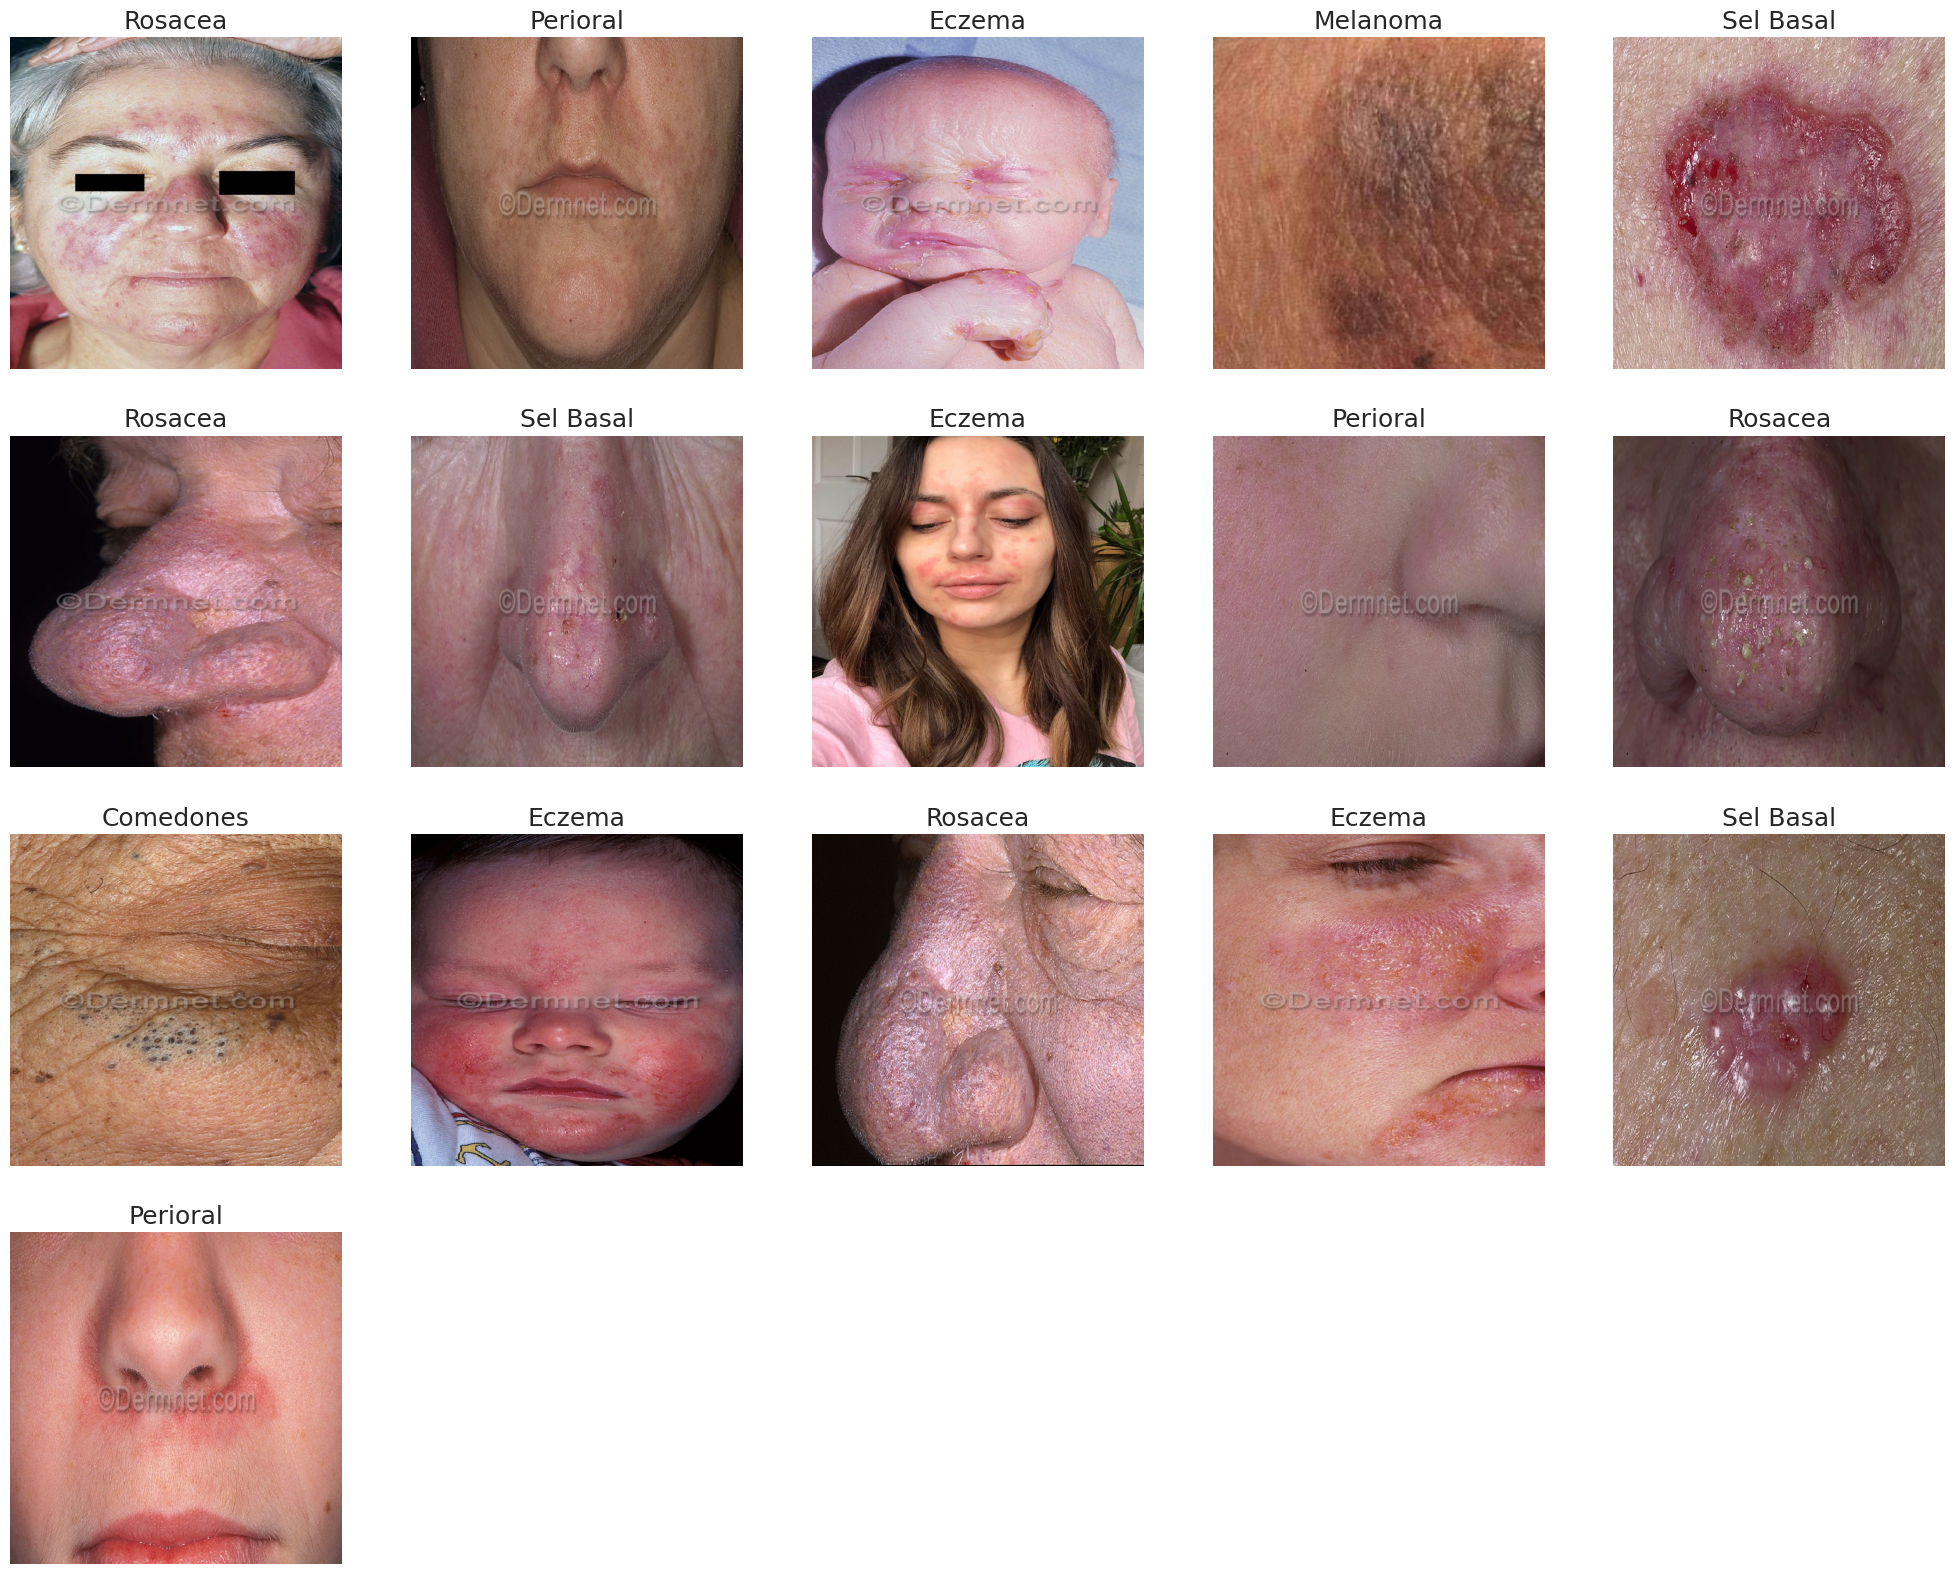

In [48]:
def plot_images_per_batch(gen):
    class_dict=gen.class_indices
    #{'Acne':0, 'Comedones':1,  'Eczema':2,  'Keratosis':3,  'Melanoma':4,  'Milia':5,  'Perioral':6,  'Rosacea':7,  'Sel Basal':8}

    # Perbedaan antara values() dan keys()
    # t_dict=gen.class_indices.values()
    # dict_values([0, 1, 2, 3, 4, 5, 6, 7, 8])
    class_dict_keywords=list(class_dict.keys()) #Atau kelas sama saja
    images,labels=next(gen) #next() mengambil gambar dari batch ke batch
    length=len(labels)
    if length<25:
        r=length
    else:
        r=25
    plt.figure(figsize=(25, 25))
    for i in range(r):
        plt.subplot(5, 5, i + 1)
        image=images[i]
        plt.imshow(image)
        index=np.argmax(labels[i])
        class_name=class_dict_keywords[index]
        plt.title(class_name, fontsize=18)
        plt.axis('off')
    plt.show()
plot_images_per_batch(train_gen)

In [10]:
#Callbacks untuk Model Training
early_stopping = keras.callbacks.EarlyStopping(monitor = "accuracy",
                               patience = 5,
                               mode = 'max')

reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=3, min_lr=1e-6)

In [11]:
def plot_training(history):
    sns.set_style('darkgrid')
    plt.figure(figsize=(8,6))
    plt.plot(history.history['accuracy'],c='blue')
    plt.plot(history.history['loss'],c='red')
    plt.plot(history.history['val_accuracy'],c='blue', linestyle='dashed')
    plt.plot(history.history['val_loss'],c='red', linestyle='dashed')
    plt.title("Accuracy and Loss Per Epochs", fontsize=20)
    plt.xlabel("Epoch", fontsize=14)
    plt.ylabel("Accuracy and Loss", fontsize=14)
    plt.legend(["Accuracy","Loss","Val_Accuracy","Val_Loss"], fontsize=14,loc=[1.02,0.5])
    plt.show()

In [12]:
# Data Augmentation Step
augment = tf.keras.Sequential([
  keras.layers.Resizing(224,224),
  keras.layers.RandomCrop(224,224, seed=62),
  keras.layers.RandomFlip("horizontal"),
  keras.layers.RandomRotation(0.3),
  keras.layers.RandomZoom(0.3),
  keras.layers.RandomContrast(0.2),
])

In [13]:
model_basic = Sequential()

model_basic.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                              input_shape=(RESIZE, RESIZE, 3)))
model_basic.add(MaxPooling2D((2,2)))
model_basic.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model_basic.add(MaxPooling2D((2,2)))
model_basic.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_basic.add(MaxPooling2D((2,2)))
model_basic.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_basic.add(MaxPooling2D((2,2)))
model_basic.add(Flatten())
model_basic.add(Dropout(0.5))
model_basic.add(Dense((NUM_CLASSES), activation='softmax'))

model_basic.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 768, 768, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 384, 384, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 384, 384, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 192, 192, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 192, 192, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 96, 96, 128)      

Epoch 1/5
94/94 [==============================] - 664s 7s/step - loss: 1.8531 - accuracy: 0.3189 - val_loss: 1.4493 - val_accuracy: 0.4829 - lr: 0.0010
Epoch 2/5
94/94 [==============================] - 50s 536ms/step - loss: 1.4025 - accuracy: 0.5053 - val_loss: 1.3845 - val_accuracy: 0.5358 - lr: 0.0010
Epoch 3/5
94/94 [==============================] - 52s 547ms/step - loss: 1.1530 - accuracy: 0.6032 - val_loss: 1.3024 - val_accuracy: 0.5327 - lr: 0.0010
Epoch 4/5
94/94 [==============================] - 51s 540ms/step - loss: 0.8103 - accuracy: 0.7237 - val_loss: 1.4990 - val_accuracy: 0.5265 - lr: 0.0010
Epoch 5/5
94/94 [==============================] - 53s 563ms/step - loss: 0.5148 - accuracy: 0.8302 - val_loss: 1.6737 - val_accuracy: 0.5701 - lr: 0.0010


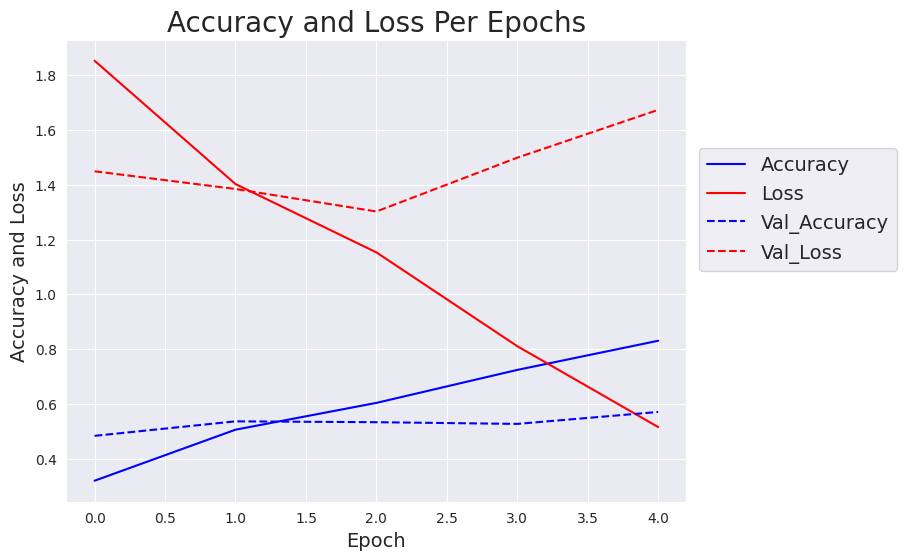

In [14]:
model_basic.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


history = model_basic.fit(train_gen,
                         epochs=5,
                         verbose=1,
                         validation_data=valid_gen,
                         validation_steps=None,
                         callbacks=[early_stopping,
                                    reduce_lr]
)
plot_training(history)

In [37]:
model_MobileNet = MobileNetV2(include_top=False,
                              weights='imagenet',
                              pooling='max')
model_MobileNet.trainable = False

i = Input(shape=(RESIZE, RESIZE, 3))
x = model_MobileNet(i, training=False)
x = Flatten()(x)
x = Dropout(0.25)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(NUM_CLASSES, activation='softmax')(x)


model_MobileNet = Model(i, x)

# Print the model summary
model_MobileNet.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_13 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Func  (None, 1280)              2257984   
 tional)                                                         
                                                                 
 flatten_2 (Flatten)         (None, 1280)              0         
                                                                 
 dropout_13 (Dropout)        (None, 1280)              0         
                                                                 
 dense_12 (Dense)            (None, 256)               327936    
                                                                 
 dropout_14 (Dropout)        (None, 256)               0         
                                                           

In [40]:
model_MobileNet.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model_MobileNet.fit(train_gen,
                         epochs=20,
                         verbose=1,
                         validation_data=valid_gen,
                         validation_steps=None,
                         callbacks=[early_stopping,
                                    reduce_lr]
)

Epoch 1/20
94/94 [==============================] - 58s 560ms/step - loss: 1.6555 - accuracy: 0.3955 - val_loss: 1.3885 - val_accuracy: 0.4829 - lr: 0.0010
Epoch 2/20
94/94 [==============================] - 52s 551ms/step - loss: 1.5950 - accuracy: 0.3975 - val_loss: 1.2887 - val_accuracy: 0.5140 - lr: 0.0010
Epoch 3/20
94/94 [==============================] - 51s 534ms/step - loss: 1.5403 - accuracy: 0.4274 - val_loss: 1.3307 - val_accuracy: 0.5296 - lr: 0.0010
Epoch 4/20
94/94 [==============================] - 50s 533ms/step - loss: 1.4982 - accuracy: 0.4534 - val_loss: 1.3113 - val_accuracy: 0.5265 - lr: 0.0010
Epoch 5/20
94/94 [==============================] - 51s 543ms/step - loss: 1.4867 - accuracy: 0.4387 - val_loss: 1.2694 - val_accuracy: 0.5234 - lr: 0.0010
Epoch 6/20
94/94 [==============================] - 50s 534ms/step - loss: 1.4391 - accuracy: 0.4547 - val_loss: 1.2376 - val_accuracy: 0.5514 - lr: 0.0010
Epoch 7/20
94/94 [==============================] - 52s 551ms/st